[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksasi/EVA/blob/master/Project12/Assignment12.ipynb)

In [1]:
# Import numpy, time, matplotlib, Keras models, backend, layers and utils
# set random seed using random.seed from numpy

from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import Callback

Using TensorFlow backend.


In [2]:
# Import cifar10 from keras datasets
# Load CIFAR10 dataset from Keras datasets module seperately as train and test datasets
# Obtain number of training and testing examples, image dimensions and number of classes

from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


In [3]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


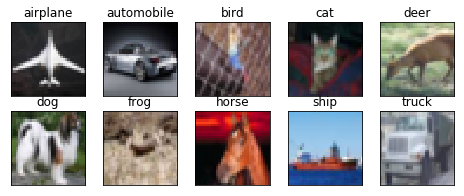

In [4]:
# Display images corresponding to each class from training dataset

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# Define function to plot summarize history for accuracy and loss

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# Define function to calculate accuracy

def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [8]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)


### Implemented the model with below specifications
1. Using Image Normalization
2. Making use of Batch Normalization
3. Making use of L2 Regularizer
4. Properly using Dropout
5. Removed Dense layers

In [9]:
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()


print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (trainX.mean(), trainX.std(), testX.mean(), testX.std()))

# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate the mean on the training dataset
datagen.fit(trainX)
#print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

# demonstrate effect on a single batch of samples
iterator = datagen.flow(trainX, trainy, batch_size=128)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

# demonstrate effect on entire training dataset
iterator = datagen.flow(trainX, trainy, batch_size=len(trainX), shuffle=False)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

Statistics train=120.708 (64.150), test=121.529 (64.061)
(128, 32, 32, 3) 0.01989002 1.0052702
(50000, 32, 32, 3) -1.6605131e-06 1.0000001


In [0]:
# Obtain train and test dataset after applying image standardization

iterator1 = datagen.flow(testX, testy, batch_size=len(testX), shuffle=False)
batch_testX, batch_testy = iterator1.next()

X_train = batchX
X_test = batch_testX

y_train=batchy
y_test=batch_testy
                        

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

### With Cutout / Random Erasing

- https://github.com/yu4u/cutout-random-erasing

In [12]:
# Import Cutout / Random Erasing implementation, especially for ImageDataGenerator in Keras from Github (https://github.com/yu4u/cutout-random-erasing)

!git clone https://github.com/ksasi/cutout-random-erasing ./random_eraser                                                   

import sys
sys.path.append("/content/random_eraser/")

Cloning into './random_eraser'...
remote: Enumerating objects: 23, done.
remote: Total 23 (delta 0), reused 0 (delta 0), pack-reused 23
Unpacking objects: 100% (23/23), done.


### Random Crop

In [0]:
# Define function to perform random crop

def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

In [0]:
# Define function to perform pre-processing i.e. perform padding i.e. 32x32 is padded to 40x40 and then perform random cropping to 32x32 size. After this perform Cutout

from random_eraser import get_random_eraser 

def pre_process(x):
  eraser = get_random_eraser(v_l=0, v_h=1) 
  x1 = np.pad(x, pad_width=((4, 4), (4, 4), (0, 0)), mode='reflect') # Perform padding so that 32x32 is changed to 40x40 by padding with 4 pixels
  x2 = random_crop(x1, (32,32)) # Perform random crop to 32×32
  x3 = eraser(x2) # Perform CutOut/Random Erasing regularization
  return x3

In [15]:
# Define the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3))) #Input channel 3, number of filters 32, filter size is 3x3 with 3 channels. Receptive field is 3x3. Output Images size 32.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization()) # BatchNormalization layer

model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) #Input channel 32, number of filters 64, filter size is 3x3 with 32 channels. Receptive field is 5x5. Output Images size 32.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization()) # BatchNormalization layer

model.add(MaxPooling2D(pool_size=(2, 2))) #Input channel 64, number of filters n/a, filter size is n/a with n/a channels. Receptive field is 10x10. Output Images size 16. This is MaxPooling layer.
model.add(Dropout(0.2)) # Droput is set to 0.2

model.add(Convolution2D(32, 1, 1)) #Input channel 64, number of filters 32, filter size is 1x1 with 64 channels. Receptive field is 10x10. Output Images size 16. This is transition block.


model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) #Input channel 32, number of filters 64, filter size is 3x3 with 32 channels. Receptive field is 12x12. Output Images size 16.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization()) # BatchNormalization layer

model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) #Input channel 64, number of filters 128, filter size is 3x3 with 64 channels. Receptive field is 14x14. Output Images size 16.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization()) # BatchNormalization layer

model.add(MaxPooling2D(pool_size=(2, 2))) #Input channel 128, number of filters n/a, filter size is n/a with n/a channels. Receptive field is 28x28. Output Images size 8. This is MaxPooling layer.
model.add(Dropout(0.3)) # Droput is set to 0.3

model.add(Convolution2D(32, 1, 1)) #Input channel 128, number of filters 32, filter size is 1x1 with 128 channels. Receptive field is 28x28. Output Images size 8. This is transition block.


model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same')) #Input channel 32, number of filters 128, filter size is 3x3 with 32 channels. Receptive field is 30x30. Output Images size 8.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization()) # BatchNormalization layer

model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same')) #Input channel 128, number of filters 256, filter size is 3x3 with 128 channels. Receptive field is 32x32. Output Images size 8.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization()) # BatchNormalization layer

model.add(MaxPooling2D(pool_size=(2, 2)))#Input channel 256, number of filters n/a, filter size is n/a with n/a channels. Receptive field is 64x64. Output Images size 4. This is MaxPooling layer.
model.add(Dropout(0.5)) # Droput is set to 0.5

model.add(Convolution2D(10, 1, 1)) #Input channel 256, number of filters 10, filter size is 1x1 with 256 channels. Receptive field is 64x64. Output Images size 4. This is transition block.

model.add(AveragePooling2D(pool_size = (4,4))) # Average Pooling layer
model.add(Flatten()) #The outputs from the previous layer are flattened


model.add(Activation('softmax'))  #Softmax activation layer.So that the values of logits are squished between 0 and 1

# Compile the model
model.compile(optimizer=optimizers.SGD(lr=1e-2, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

W0726 13:56:48.621027 140525799266176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
W0726 13:56:48.660668 140525799266176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 13:56:48.666536 140525799266176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0726 13:56:48.712666 140525799266176 deprecation_wrapper.py

### Finding a good learning rate & training with OneCycleLR

In [16]:
# Import One-Cycle Learning rate policy (Keras) (https://github.com/amitkayal/keras-one-cycle)

!git clone https://github.com/ksasi/keras-one-cycle ./clr
  
import sys
sys.path.append("/content/clr/")

Cloning into './clr'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 238 (delta 18), reused 0 (delta 0), pack-reused 208
Receiving objects: 100% (238/238), 3.19 MiB | 5.53 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [17]:
# Finding good learning rate using LRFinder (https://github.com/ksasi/keras-one-cycle/blob/master/README.md)

from clr import LRFinder

lr_callback = LRFinder(num_samples = X_train.shape[0] , batch_size = 512, minimum_lr = 1e-5, maximum_lr = 10, validation_data = (X_test, Y_test), 
                       lr_scale='exp', validation_sample_rate=5,
                       save_dir='/content/lr')


# Ensure that number of epochs = 1 when calling fit()
model.fit_generator(datagen.flow(X_train, Y_train, batch_size = 512),samples_per_epoch = X_train.shape[0], nb_epoch = 1, validation_data = (X_test, Y_test), verbose=1, callbacks=[lr_callback] )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<clr.LRFi..., steps_per_epoch=97, epochs=1)`
  # Remove the CWD from sys.path while we load stuff.
W0726 13:57:14.871536 140525799266176 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_sup

Epoch 1/1
96/97 [============================>.] - ETA: 0s - loss: 3.2452 - acc: 0.1351 - LRFinder: val_loss: 15.0465 - lr = 8.67249772 
 - LRFinder: val_loss: 15.0297 - lr = 9.99999691 
97/97 [==============================] - 32s 335ms/step - loss: 3.3626 - acc: 0.1349 - val_loss: 14.9667 - val_acc: 0.1000
	LR Finder : Saved the losses and learning rate values in path : {/content/lr}


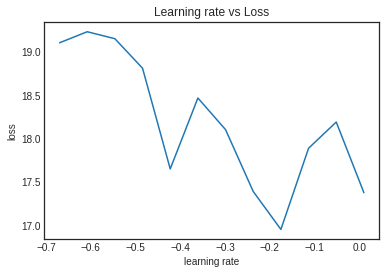

In [23]:
lr_callback.plot_schedule(clip_beginning=70, clip_endding= 15)

#lr_callback.plot_schedule()

### Inferred learning rate value from above plot 

#### learning rate value from X-axis is -0.43  (The values are in log 10 scale (since exp was used for lr_scale))

#### Actual learning maximum learning rate is 10 ^ (x) which is 10^(-0.43) ~ 0.3715 i.e. 0.4

In [24]:
# Define the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3))) #Input channel 3, number of filters 32, filter size is 3x3 with 3 channels. Receptive field is 3x3. Output Images size 32.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization()) # BatchNormalization layer

model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) #Input channel 32, number of filters 64, filter size is 3x3 with 32 channels. Receptive field is 5x5. Output Images size 32.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization()) # BatchNormalization layer

model.add(MaxPooling2D(pool_size=(2, 2))) #Input channel 64, number of filters n/a, filter size is n/a with n/a channels. Receptive field is 10x10. Output Images size 16. This is MaxPooling layer.
model.add(Dropout(0.2)) # Droput is set to 0.2

model.add(Convolution2D(32, 1, 1)) #Input channel 64, number of filters 32, filter size is 1x1 with 64 channels. Receptive field is 10x10. Output Images size 16. This is transition block.


model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) #Input channel 32, number of filters 64, filter size is 3x3 with 32 channels. Receptive field is 12x12. Output Images size 16.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization()) # BatchNormalization layer

model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) #Input channel 64, number of filters 128, filter size is 3x3 with 64 channels. Receptive field is 14x14. Output Images size 16.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization()) # BatchNormalization layer

model.add(MaxPooling2D(pool_size=(2, 2))) #Input channel 128, number of filters n/a, filter size is n/a with n/a channels. Receptive field is 28x28. Output Images size 8. This is MaxPooling layer.
model.add(Dropout(0.3)) # Droput is set to 0.3

model.add(Convolution2D(32, 1, 1)) #Input channel 128, number of filters 32, filter size is 1x1 with 128 channels. Receptive field is 28x28. Output Images size 8. This is transition block.


model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same')) #Input channel 32, number of filters 128, filter size is 3x3 with 32 channels. Receptive field is 30x30. Output Images size 8.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization()) # BatchNormalization layer

model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same')) #Input channel 128, number of filters 256, filter size is 3x3 with 128 channels. Receptive field is 32x32. Output Images size 8.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization()) # BatchNormalization layer

model.add(MaxPooling2D(pool_size=(2, 2)))#Input channel 256, number of filters n/a, filter size is n/a with n/a channels. Receptive field is 64x64. Output Images size 4. This is MaxPooling layer.
model.add(Dropout(0.5)) # Droput is set to 0.5

model.add(Convolution2D(10, 1, 1)) #Input channel 256, number of filters 10, filter size is 1x1 with 256 channels. Receptive field is 64x64. Output Images size 4. This is transition block.

model.add(AveragePooling2D(pool_size = (4,4))) # Average Pooling layer
model.add(Flatten()) #The outputs from the previous layer are flattened


model.add(Activation('softmax'))  #Softmax activation layer.So that the values of logits are squished between 0 and 1

# Compile the model
model.compile(optimizer=optimizers.SGD(lr=1e-2, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same"

### Training with OneCycleLR aka  "SUPER CONVERGENCE"

In [0]:
# Define OneCycleLR

from clr import OneCycleLR

lr_manager = OneCycleLR(num_samples = X_train.shape[0], max_lr=0.4, verbose=True, batchsize = 512, end_percentage=0.1, scale_percentage=None,
                        maximum_momentum=0.9, minimum_momentum=0.9)

/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py:440: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  image.ImageDataGenerator.__init__).args:
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<clr.OneC...,

Class: <clr.OneCycleLR object at 0x7fce50923ac8>
Values: {'validation_data': None, 'model': <keras.engine.sequential.Sequential object at 0x7fce508c3da0>, 'initial_lr': 0.4, 'end_percentage': 0.1, 'scale': 0.1, 'max_momentum': 0.9, 'min_momentum': 0.9, 'verbose': True, '_update_momentum': True, 'clr_iterations': 0.0, 'history': {}, 'epochs': None, 'batch_size': 512, 'samples': 50000, 'steps': None, 'num_iterations': None, 'mid_cycle_id': None, 'params': {'epochs': 50, 'steps': 97, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}}


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


Epoch 1/50
97/97 [==============================] - 11s 112ms/step - loss: 1.8910 - acc: 0.3349 - val_loss: 2.1521 - val_acc: 0.2924
 - lr: 0.05542 - momentum: 0.90 
Epoch 2/50
97/97 [==============================] - 11s 110ms/step - loss: 1.5475 - acc: 0.4479 - val_loss: 1.6663 - val_acc: 0.4607
 - lr: 0.07100 - momentum: 0.90 
Epoch 3/50
97/97 [==============================] - 10s 102ms/step - loss: 1.3747 - acc: 0.5224 - val_loss: 1.7797 - val_acc: 0.4522
 - lr: 0.08659 - momentum: 0.90 
Epoch 4/50
97/97 [==============================] - 10s 103ms/step - loss: 1.2809 - acc: 0.5562 - val_loss: 1.7999 - val_acc: 0.4954
 - lr: 0.10217 - momentum: 0.90 
Epoch 5/50
97/97 [==============================] - 10s 104ms/step - loss: 1.2267 - acc: 0.5763 - val_loss: 1.4450 - val_acc: 0.5688
 - lr: 0.11775 - momentum: 0.90 
Epoch 6/50
97/97 [==============================] - 10s 104ms/step - loss: 1.1624 - acc: 0.6045 - val_loss: 1.2432 - val_acc: 0.6037
 - lr: 0.13333 - momentum: 0.90 
Epoc

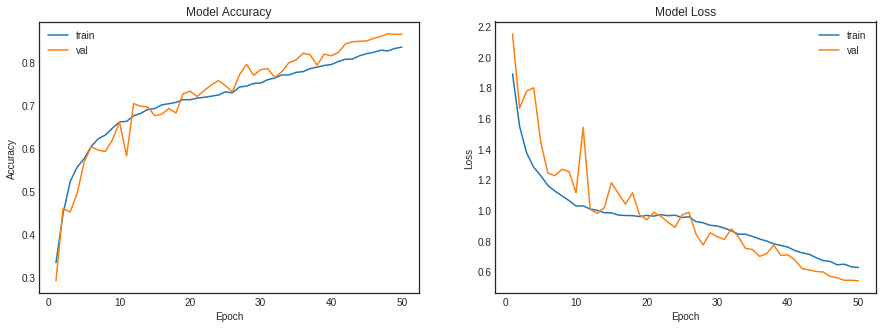

Top accuracy on test data is: 86.43


In [26]:
# Train the model using fit_generator function. Also calculate and display total time taken for training. Along with this plot summarize history for accuracy and loss. Display best validatino accuracy.
# Training with OneCycleLR

from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(zoom_range=0.0,horizontal_flip=True, vertical_flip=True, preprocessing_function = pre_process)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = 512),samples_per_epoch = X_train.shape[0], nb_epoch = 50, validation_data = (X_test, Y_test), verbose=1, callbacks=[lr_manager])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)

print ("Top accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model))

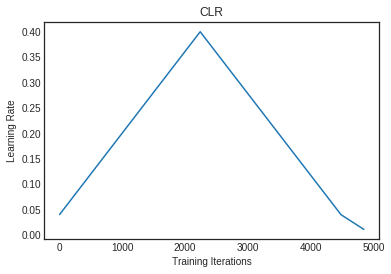

In [27]:
# Plot of Learning Rate Vs Training Iterations

plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR")
plt.plot(lr_manager.history['lr'])
plt.show()

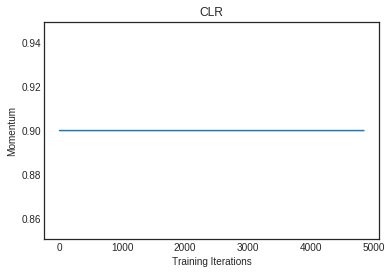

In [28]:
# Plot of momentum Vs Training Iterations

plt.xlabel('Training Iterations')
plt.ylabel('Momentum')
plt.title("CLR")
plt.plot(lr_manager.history['momentum'])
plt.show()

###  Training :

*   Standard Cifar10 transformations i.e. pad 4 pixels to 40×40, crop back to 32×32, and randomly flip left and right were applied 
*   CutOut augmentation is applied as a regularization measure
*   Training is carried out using OneCycle Policy aka **SUPER CONVERGENCE** with Learning rate 0.4, momentum 0.9 and batch size of 512
*   Training is carried out for 50 epochs and final validation accuracy of 86.43 is achieved
*   Total training took around 508.50 seconds i.e. 8.475 minutes



### **References & Attributions:**

*   https://mc.ai/tutorial-2-94-accuracy-on-cifar10-in-2-minutes/
*   https://github.com/titu1994/keras-one-cycle
*   https://github.com/ksasi/keras-one-cycle
*   https://github.com/yu4u/cutout-random-erasing
*   Keras (https://keras.io/)
*   Tensorflow 2.1 (https://www.tensorflow.org/api_docs/python/)

*Disclaimer: The contents of this notebook are used for educational purposes i.e. for learning and research.*